# Model refinement / new approaches
Test a multi-class classification approach that classifies monoculture and agroforestry plantations separately.


In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')
import ptype_prepare_data as pp
from model import ptype_run_preds as rp
from model import tune 
from model import feature_selection as fs
import os
import glob
from catboost import CatBoostClassifier
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import seaborn as sns
import rasterio as rs
from rasterio.merge import merge
from datetime import datetime
import numpy as np
#import stage_train as train

%load_ext autoreload
%autoreload 2

# [v15] Multi-class Classification Pipeline

In [10]:
# train classification cat model with multi-class data (v14 and v15)
X, y = pp.create_xy(['v14', 'v15'], classes='multi', drop_prob=False, drop_feats=False, verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v15')

53.0 unknown plots dropped
Plot id 14027 has no cloud free imagery and will be removed.
2.0 unknown plots dropped
Training data includes 244 plots.
Class count {0.0: 5044, 1.0: 1319, 2.0: 41461}


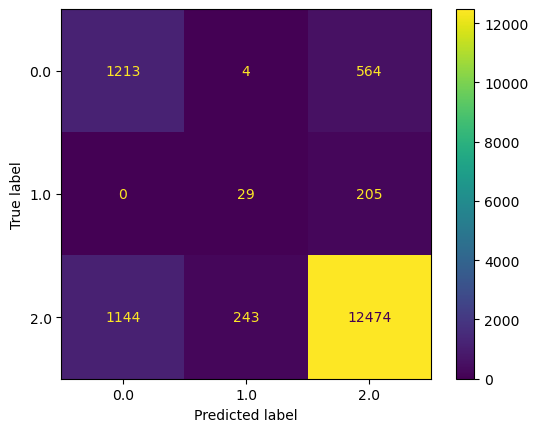

In [12]:
# check out results
with open(f'../models/cat_v15.pkl', 'rb') as file:  
    model = pickle.load(file)

# Confusion Matrix
cm = confusion_matrix(y_test, pred, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot();

In [14]:
# train regression model with multi-class data (v14 and v15)
# applies manual scaling

X, y = pp.create_xy(['v14', 'v15'], classes='multi', drop_prob=False, drop_feats=False, verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale_manual(X, y, 'v15')

In [15]:
df = rp.fit_eval_regressor(X_train_ss, X_test_ss, y_train, y_test, 'rfr','v15')

In [16]:
df

,model,class,cv,train_score,test_score,roc_auc,precision,recall,f1,date
0,rfr_v15,n/a,0.2128,0.9535,0.1946,NaN,NaN,NaN,NaN,2023-01-24


In [23]:
import hickle as hkl
feats_file = f'../tmp/ashanti/1658/1098/raw/feats/1658X1098Y_feats.hkl'
feats_raw = hkl.load(feats_file).astype(np.float32)

# adjust TML predictions feats[0] to match training data (0-1)
# adjust shape by rolling axis (65, 614, 618) ->  (618, 614, 65) 
feats_raw[0] = feats_raw[0] / 100 
feats_raw[1:] = feats_raw[1:] / 1000  # feats are multiplyed by 1000 before saving
feats_rolled = np.rollaxis(feats_raw, 0, 3)
feats_rolled = np.rollaxis(feats_rolled, 0, 2)

In [31]:
X, y = pp.create_xy(['v14', 'v15'], classes='multi', drop_prob=False, drop_feats=False, verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)

53.0 unknown plots dropped
Plot id 14027 has no cloud free imagery and will be removed.
2.0 unknown plots dropped
Training data includes 244 plots.
Class count {0.0: 5044, 1.0: 1319, 2.0: 41461}


In [33]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [34]:
class_weights

{0.0: 3.2636632955358054, 1.0: 9.81505376344086, 2.0: 0.3858454106280193}

In [36]:
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v15')

# Adapt Multi-class Labels for Binary Classification Pipeline

In [102]:
# pull in one of the labels plots and confirm how the change will be made
# look at labels for plot 15044
idx = '15044'
directory = '../data/train-labels/'
multi_labels = np.load(directory + str(idx) + '.npy')
binary_labels = multi_labels.copy()
binary_labels[binary_labels == 2] = 1
multi_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1])

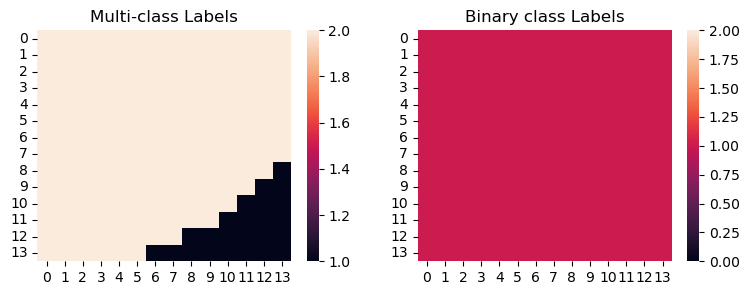

In [94]:
plt.figure(figsize=(9,3)) 

ax1 = plt.subplot(1,2,1)
sns.heatmap(multi_labels.reshape(14,14))
plt.title('Multi-class Labels');

ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
sns.heatmap(binary_labels.reshape(14,14), vmin=0.0, vmax=2.0)
plt.title('Binary class Labels');

In [14]:
np.finfo(np.float32)

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

In [3]:
# train classification cat model that combines the single and multi class training data
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[],
                    verbose=True)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v15_2')


53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Training data includes 557 plots.
Class count {0.0: 30139, 1.0: 79033}


In [5]:
class_count = {0.0: 30139, 1.0: 79033}
scale_pos = class_count[0] / class_count[1]
scale_pos

0.3813470322523503

In [35]:
30139 / (30139 + 79033)

0.276068955409812

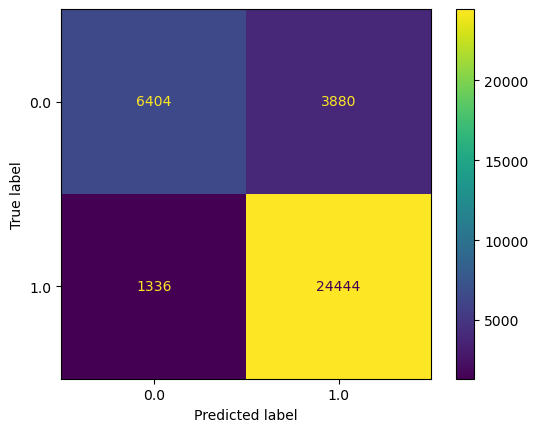

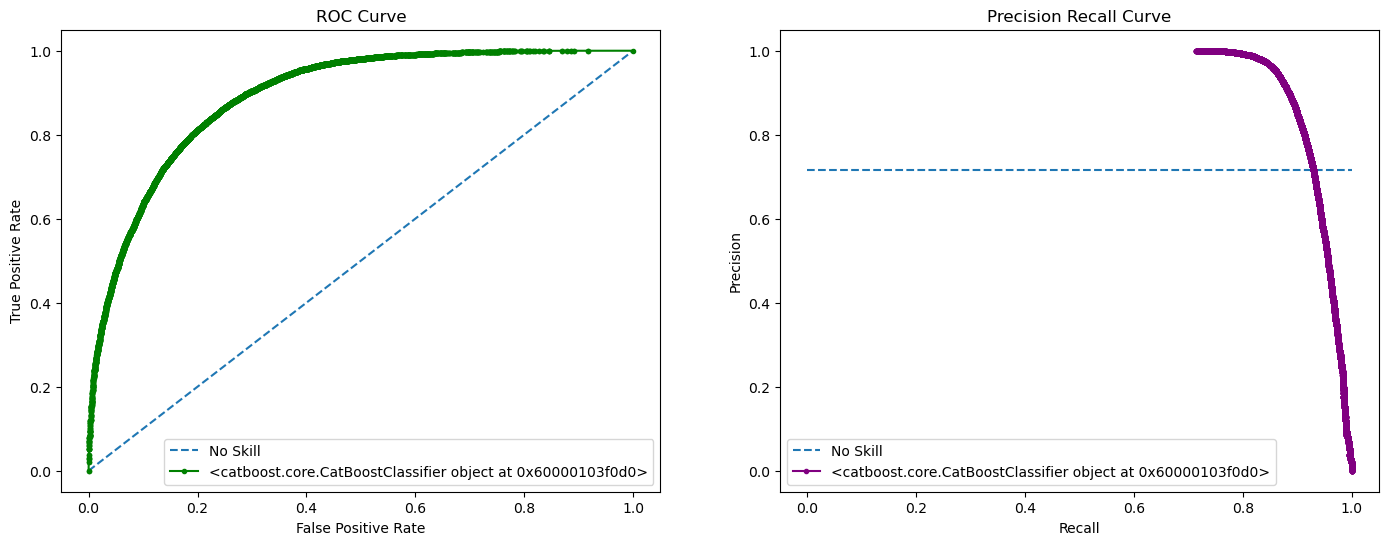

In [44]:
viz.cm_roc_pr('cat_v15_2', y_test, pred, probs_pos)

# [v17] Address Class Imbalance

In [9]:
## Address class imbalance by adding more training data in the negative class (addition of v17)
feats = [0, 3, 4, 7, 9, 11, 12, 16, 18, 19, 20, 24, 25, 28, 29, 30, 32, 34, 36, 39, 41, 42, 44, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_feats=False, 
                    feature_select=feats,
                    verbose=False)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)

37.0 plots labeled unknown were dropped from v08.
53.0 plots labeled unknown were dropped from v14.
2.0 plots labeled unknown were dropped from v15.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be re

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 668/668 [11:07<00:00,  1.00it/s]

Class count {0.0: 43334, 1.0: 87594}


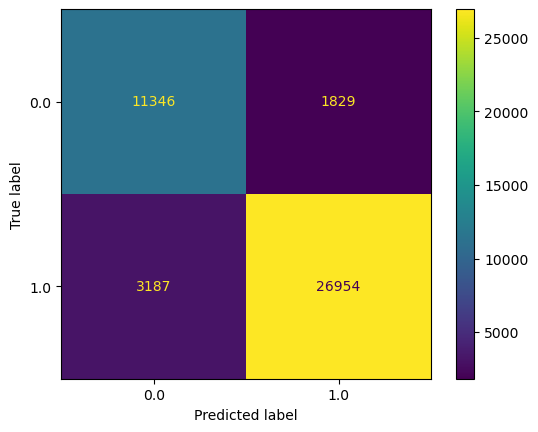

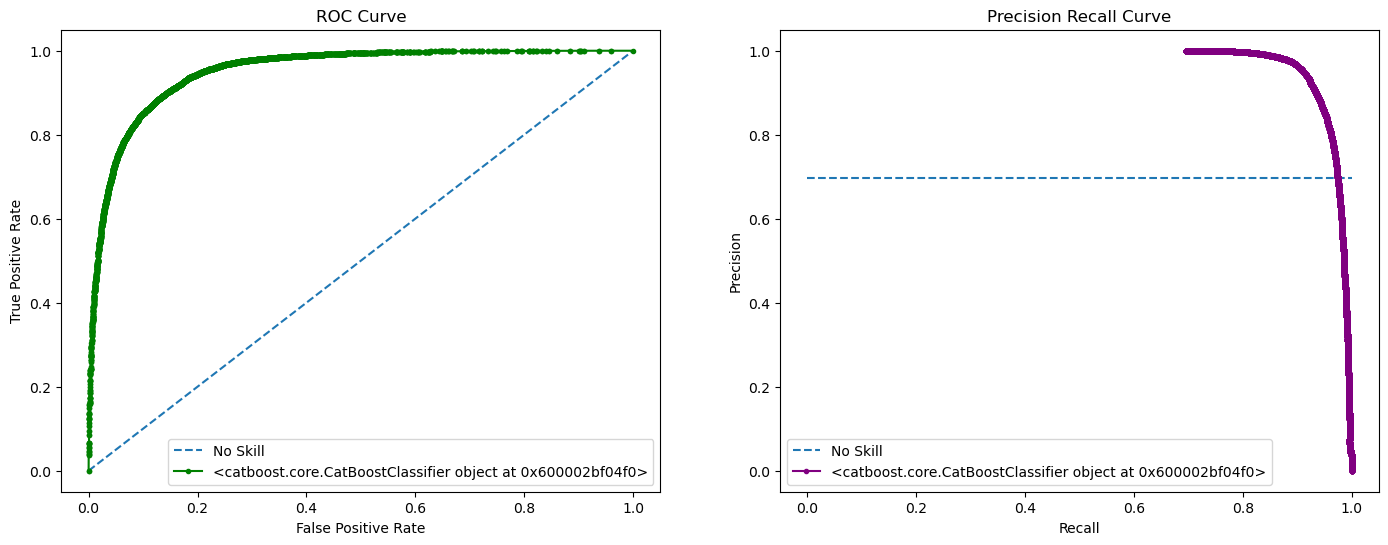

In [10]:
viz.cm_roc_pr('cat_v17_tuned', y_test, pred, probs_pos)

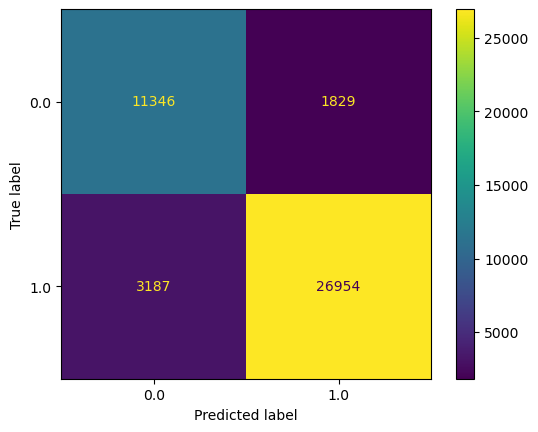

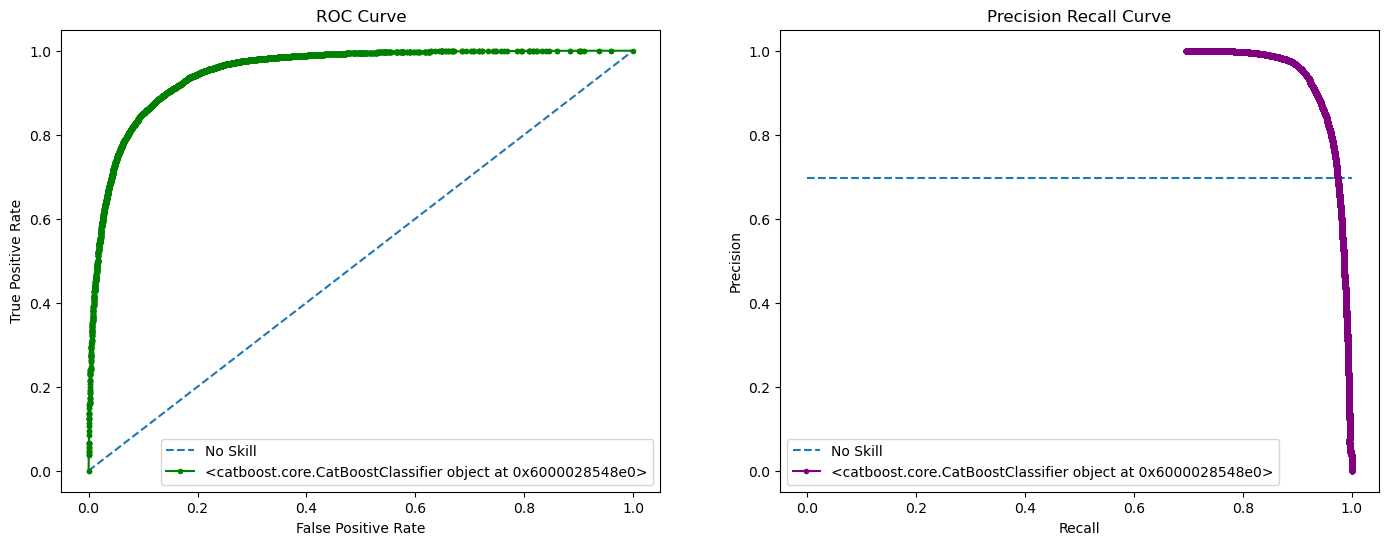

In [11]:
viz.cm_roc_pr('cat_v17', y_test, pred, probs_pos)

# [v17] Regression Exercise to Understand Prediction Confidence

In [17]:
# train a random forest regressor baseline model
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[],
                    verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
eval_df = rp.fit_eval_regressor(X_train_ss, X_test_ss, y_train, y_test, 'rfr','v17')

53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be removed.


# [v17] Fast GLCM Texture Features
Test the incorporation of texture features using fast_glcm implementation.

In [6]:
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_feats=False, 
                    feature_select=[], 
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v17_txt')

37.0 plots labeled unknown were dropped from v08.
53.0 plots labeled unknown were dropped from v14.
2.0 plots labeled unknown were dropped from v15.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be re

100%|█████████████████████████████████████████| 668/668 [08:26<00:00,  1.32it/s]


Class count {0.0: 43334, 1.0: 87594}
Computing class weights...


In [7]:
# now do scaled for feature selection
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_feats=False, 
                    feature_select=[], 
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale_manual(X, y, 'v17_txt')
y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v17_txt_scaled')

37.0 plots labeled unknown were dropped from v08.
53.0 plots labeled unknown were dropped from v14.
2.0 plots labeled unknown were dropped from v15.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be re

100%|█████████████████████████████████████████| 668/668 [11:36<00:00,  1.04s/it]


Class count {0.0: 43334, 1.0: 87594}
Computing class weights...


In [5]:
# 5/8/23 using the top 40 features from the model above
# train a model cat_v17_tuned with previously identified hyperparams
# to use in the deployment pipeline
feats = [0, 3, 11, 12, 18, 19, 20, 24, 25, 29, 30, 32, 36, 41, 42, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 70, 72, 74, 76, 77, 78, 79, 80]

X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_feats=False, 
                    feature_select=feats, 
                    verbose=False)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_catboost(X_train_ss, 
                                                      X_test_ss, 
                                                      y_train, 
                                                      y_test, 
                                                      v_train_data='v17_tuned')


37.0 plots labeled unknown were dropped from v08.
53.0 plots labeled unknown were dropped from v14.
2.0 plots labeled unknown were dropped from v15.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be re

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 668/668 [05:32<00:00,  2.01it/s]


Class count {0.0: 43334, 1.0: 87594}
Computing class weights...


Now deploy the model using these features
`0 3 11 12 18 19 20 24 25 29 30 32 36 41 42 48 49 50 51 52 53 55 57 58 59 60 61 62 63 64`

In [7]:
# now deploy the model with these features (we know the deployment pipeline will calculatè)
orig = [0, 3, 11, 12, 18, 19, 20, 24, 25, 29, 30, 32, 36, 41, 42, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 64]


# [v19] Updated photointerpretation / labeling

In [13]:
## Multi-class model with full set of training data and texture
# v18 and v19 were v11 and v17 but now have multiclass labels
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19'], 
                    classes='multi',
                    drop_feats=False, 
                    feature_select=[],
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v19')

37.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
53.0 plots labeled unknown were dropped.
Plot id 14027 has no cloud free imagery and will be removed.
2.0 plots labeled unknown were dropped.
49.0 plots labeled unknown were dropped.
Plot id 18109 has no cloud free imagery and will be removed.
Plot id 18132 has no cloud free imagery and will be removed.
23.0 plots labeled unknown were dropped.
Plo

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 695/695 [09:03<00:00,  1.28it/s]


Class count {0.0: 46175, 1.0: 14038, 2.0: 76007}
REMINDER: hyperparams are hard coded.


In [14]:
# now train scaled model for feature selection
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19'], 
                    classes='multi',
                    drop_feats=False, 
                    feature_select=[],
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale_manual(X, y, 'v19')
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v19_scaled')

37.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
53.0 plots labeled unknown were dropped.
Plot id 14027 has no cloud free imagery and will be removed.
2.0 plots labeled unknown were dropped.
49.0 plots labeled unknown were dropped.
Plot id 18109 has no cloud free imagery and will be removed.
Plot id 18132 has no cloud free imagery and will be removed.
23.0 plots labeled unknown were dropped.
Plo

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 695/695 [12:00<00:00,  1.04s/it]


Class count {0.0: 46175, 1.0: 14038, 2.0: 76007}
REMINDER: hyperparams are hard coded.


In [ ]:
# cat_v19_fs trained in tuning notebook

In [16]:
# now train with feature selection using these feats
v19_ss_feats = [0, 1, 5, 6, 9, 11, 14, 16, 19, 20, 21, 28, 29, 31, 32, 34, 36, 38, 39, 43, 44, 47, 50, 51, 52, 57, 58, 59, 60, 61, 63, 64, 69, 70, 71, 72, 76, 77, 78, 80]
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19'], 
                    classes='multi',
                    drop_feats=False, 
                    feature_select=v19_ss_feats,
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v19_tuned')


37.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
53.0 plots labeled unknown were dropped.
Plot id 14027 has no cloud free imagery and will be removed.
2.0 plots labeled unknown were dropped.
49.0 plots labeled unknown were dropped.
Plot id 18109 has no cloud free imagery and will be removed.
Plot id 18132 has no cloud free imagery and will be removed.
23.0 plots labeled unknown were dropped.
Plo

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 695/695 [15:58<00:00,  1.38s/it]


Class count {0.0: 46175, 1.0: 14038, 2.0: 76007}
REMINDER: hyperparams are hard coded.


# [v20] Addressing Class Imbalance
Incorporating additional training data on monoculture plantations to establish a more balanced distribution of classes. Hopefully this will improve the classification accuracy between the monoculture and agroforestry class.

In [18]:
total = 56586 + 39237 + 62741
classes = {0.0: 56586, 1.0: 39237, 2.0: 62741}
print(f'Non-plantation %{(classes[0]/total)*100}, Monoculture %{(classes[1]/total)*100}, Agroforestry %{(classes[2]/total)*100}')
      

Non-plantation %35.68653666658258, Monoculture %24.74521328927121, Agroforestry %39.56825004414621


In [3]:
# train unscaled v20 model
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes='multi',
                    drop_feats=False, 
                    feature_select=[],
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v20')

186 plots labeled "unknown" were dropped: [8015, 8019, 8023, 8035, 8044, 8049, 8066, 8081, 8085, 8092, 8097, 8103, 8104, 8115, 8116, 8127, 8136, 8140, 8144, 8148, 8157, 8161, 8162, 8163, 8166, 8167, 8172, 8178, 8180, 8184, 8185, 8196, 8200, 8201, 8205, 8207, 8209, 14004, 14015, 14018, 14029, 14030, 14044, 14046, 14063, 14066, 14076, 14077, 14087, 14092, 14113, 14118, 14119, 14120, 14127, 14129, 14133, 14134, 14135, 14139, 14141, 14144, 14149, 14151, 14152, 14153, 14154, 14155, 14158, 14159, 14163, 14170, 14171, 14172, 14177, 14186, 14187, 14189, 14191, 14207, 14210, 14212, 14214, 14220, 14222, 14224, 14230, 14232, 14235, 14238, 15010, 15046, 18058, 18080, 18082, 18101, 18104, 18105, 18106, 18107, 18108, 18111, 18114, 18115, 18116, 18118, 18122, 18125, 18126, 18127, 18129, 18130, 18139, 18141, 18142, 18144, 18151, 18153, 18162, 18164, 18171, 18177, 18178, 18179, 18180, 18182, 18183, 18184, 18186, 18188, 18189, 18190, 18191, 18192, 18193, 18194, 18195, 18196, 18197, 18198, 18200, 19085, 

100%|█████████████████████████████████████████████████████| 809/809 [02:41<00:00,  5.02it/s]


Class count {0.0: 56586, 1.0: 39237, 2.0: 62741}


In [2]:
# [v20] Redo with fixed training pipeline 
# train unscaled model for feature selection
# no hyperparameters except weights

X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes='multi',
                    drop_feats=False, 
                    feature_select=[],
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale_manual(X, y, 'v20')
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v20_scaled')

186 plots labeled "unknown" were dropped: [8015, 8019, 8023, 8035, 8044, 8049, 8066, 8081, 8085, 8092, 8097, 8103, 8104, 8115, 8116, 8127, 8136, 8140, 8144, 8148, 8157, 8161, 8162, 8163, 8166, 8167, 8172, 8178, 8180, 8184, 8185, 8196, 8200, 8201, 8205, 8207, 8209, 14004, 14015, 14018, 14029, 14030, 14044, 14046, 14063, 14066, 14076, 14077, 14087, 14092, 14113, 14118, 14119, 14120, 14127, 14129, 14133, 14134, 14135, 14139, 14141, 14144, 14149, 14151, 14152, 14153, 14154, 14155, 14158, 14159, 14163, 14170, 14171, 14172, 14177, 14186, 14187, 14189, 14191, 14207, 14210, 14212, 14214, 14220, 14222, 14224, 14230, 14232, 14235, 14238, 15010, 15046, 18058, 18080, 18082, 18101, 18104, 18105, 18106, 18107, 18108, 18111, 18114, 18115, 18116, 18118, 18122, 18125, 18126, 18127, 18129, 18130, 18139, 18141, 18142, 18144, 18151, 18153, 18162, 18164, 18171, 18177, 18178, 18179, 18180, 18182, 18183, 18184, 18186, 18188, 18189, 18190, 18191, 18192, 18193, 18194, 18195, 18196, 18197, 18198, 18200, 19085, 

100%|█████████████████████████████████████████████████████████████████████| 809/809 [02:33<00:00,  5.28it/s]


Class count {0.0: 56586, 1.0: 39237, 2.0: 62741}


In [ ]:
## TEST train fs and scaled model
v20_feats = [0, 1, 5, 6, 8, 9, 11, 14, 16, 19, 20, 21, 28, 31, 33, 34, 36, 37, 39, 44, 45, 47, 48, 49, 50, 51, 52, 57, 58, 60, 61, 62, 63, 64, 72, 76, 77, 78, 79, 80]
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes='multi',
                    drop_feats=False, 
                    feature_select=v20_feats,
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v20_fs')

In [5]:
# now trained tuned and fs model
v20_feats = [0, 1, 5, 6, 8, 9, 11, 14, 16, 19, 20, 21, 28, 31, 33, 34, 36, 37, 39, 44, 45, 47, 48, 49, 50, 51, 52, 57, 58, 60, 61, 62, 63, 64, 72, 76, 77, 78, 79, 80]
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes='multi',
                    drop_feats=False, 
                    feature_select=v20_feats,
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v20_tuned')

186 plots labeled "unknown" were dropped: [8015, 8019, 8023, 8035, 8044, 8049, 8066, 8081, 8085, 8092, 8097, 8103, 8104, 8115, 8116, 8127, 8136, 8140, 8144, 8148, 8157, 8161, 8162, 8163, 8166, 8167, 8172, 8178, 8180, 8184, 8185, 8196, 8200, 8201, 8205, 8207, 8209, 14004, 14015, 14018, 14029, 14030, 14044, 14046, 14063, 14066, 14076, 14077, 14087, 14092, 14113, 14118, 14119, 14120, 14127, 14129, 14133, 14134, 14135, 14139, 14141, 14144, 14149, 14151, 14152, 14153, 14154, 14155, 14158, 14159, 14163, 14170, 14171, 14172, 14177, 14186, 14187, 14189, 14191, 14207, 14210, 14212, 14214, 14220, 14222, 14224, 14230, 14232, 14235, 14238, 15010, 15046, 18058, 18080, 18082, 18101, 18104, 18105, 18106, 18107, 18108, 18111, 18114, 18115, 18116, 18118, 18122, 18125, 18126, 18127, 18129, 18130, 18139, 18141, 18142, 18144, 18151, 18153, 18162, 18164, 18171, 18177, 18178, 18179, 18180, 18182, 18183, 18184, 18186, 18188, 18189, 18190, 18191, 18192, 18193, 18194, 18195, 18196, 18197, 18198, 18200, 19085, 

100%|█████████████████████████████████████████████████████████████████████| 809/809 [07:03<00:00,  1.91it/s]


Class count {0.0: 56586, 1.0: 39237, 2.0: 62741}


## [v20] Regression 

In [7]:
## train catboost regressor
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes='multi',
                    drop_feats=False, 
                    feature_select=[],
                    verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
preds = rp.fit_eval_regressor(X_train_ss, 
                             X_test_ss, 
                             y_train, 
                             y_test, 
                             'catr',
                             'v20')

In [11]:
# preds are one dimensional array, how to split btw bands?
preds.shape

(52332,)

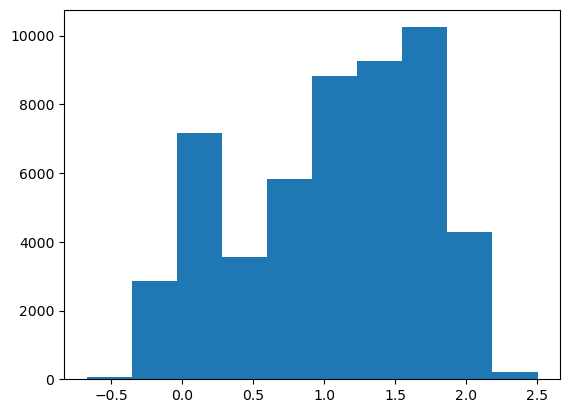

In [13]:
plt.hist(preds);

In [9]:
df = pd.read_csv('../models/mvp_scores.csv')

In [10]:
df.tail()

,model,class,feats,cv,train_score,test_score,roc_auc,precision,recall,f1,date
179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,cat_v19_tuned,multi,40.0,0.8048,0.9647,0.8283,NaN,0.8263,0.8283,0.8256,9/21/23
181,catr_v20,NaN,81.0,0.5579,0.7192,0.5508,NaN,NaN,NaN,NaN,2023-10-04
182,cat_v20,multi,81.0,0.8185,0.9665,0.8243,NaN,0.8274,0.8243,0.8238,2023-10-05
183,catr_v20,NaN,81.0,0.5579,0.7192,0.5508,NaN,NaN,NaN,NaN,2023-10-05


## Train with ARD

In [5]:
# with new ARD, ARD feats and scaling function
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    binary=False,
                    feature_select=[],
                    verbose=False)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale(X, 
                                                              y, 
                                                              scale=True, 
                                                              v_train_data='v20_ARD')

y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v20_ARD')

186 plots labeled "unknown" were dropped.
127 plots without ARD were dropped.
Training data batch includes: 723 plots.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 723/723 [00:43<00:00, 16.52it/s]


Class count {0.0: 50836, 1.0: 36555, 2.0: 54317}


In [4]:
non = 50836
mono = 36555
af = 54317
total = non+mono+af
classes = {0.0: non, 1.0: mono, 2.0: af}
print(f'Non-plantation %{(classes[0]/total)*100}, Monoculture %{(classes[1]/total)*100}, Agroforestry %{(classes[2]/total)*100}')
      

Non-plantation %35.87376859457476, Monoculture %25.796003048522316, Agroforestry %38.33022835690293


In [6]:
# with hyperparameter tuning
v20_feats = [0, 4, 5, 7, 9, 11, 12, 14, 16, 19, 21, 29, 33, 34, 36, 37, 39, 44, 46, 48, 49, 50, 51, 52, 57, 58, 59, 60, 61, 62, 63, 64, 70, 71, 72, 75, 76, 77, 78, 80]
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    binary=False,
                    feature_select=v20_feats,
                    verbose=False)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale(X, 
                                                              y, 
                                                              scale=False, 
                                                              v_train_data='v20_ARD')

y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v20_ARD_tuned')

186 plots labeled "unknown" were dropped.
127 plots without ARD were dropped.
Training data batch includes: 723 plots.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 723/723 [01:05<00:00, 11.09it/s]


Class count {0.0: 50836, 1.0: 36555, 2.0: 54317}


# 4 Class Classifier 

In [3]:
# with new ARD, ARD feats and scaling function
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes=4,
                    feature_select=[],
                    verbose=False)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale(X, 
                                                              y, 
                                                              scale=True, 
                                                              v_train_data='v20_4')

y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v20_4')

186 plots labeled "unknown" were dropped.
127 plots without ARD were dropped.
Training data batch includes: 723 plots.


100%|████████████████████████████████████████████████████████████████████| 723/723 [01:13<00:00,  9.87it/s]


Class count {0.0: 7939, 1.0: 36555, 2.0: 54317, 3.0: 42897}


In [1]:
non = 7939
mono = 36555
af = 54317
natural = 42897
total = non+mono+af+natural
classes = {0.0: non, 1.0: mono, 2.0: af, 3.0:natural}
print(f'Non-tree %{(classes[0]/total)*100}')
print(f'Monoculture %{(classes[1]/total)*100}')
print(f'Agroforestry %{(classes[2]/total)*100}') 
print(f'Natural %{(classes[3]/total)*100}')

Non-tree %5.602365427498801
Monoculture %25.796003048522316
Agroforestry %38.33022835690293
Natural %30.27140316707596


# [v21] Comb ARD and Raw Data

In [4]:
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes=4,
                    feature_select=[],
                    verbose=False)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale(X, 
                                                              y, 
                                                              scale=True, 
                                                              v_train_data='v21')

y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v21')

186 plots labeled "unknown" were dropped.
127 plots did not have ARD; 115 plots will use raw data.
Training data batch includes: 838 plots.


100%|█████████████████████████████████████████| 115/115 [00:17<00:00,  6.75it/s]


Class count {0.0: 28909, 1.0: 31304, 2.0: 62937, 3.0: 41098}


In [5]:
feat_df, v21_top_feats = fs.feature_selection('cat_v21', 40)
print(v21_top_feats)

[0, 5, 7, 10, 11, 14, 16, 17, 19, 23, 33, 34, 36, 37, 38, 39, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 57, 58, 59, 60, 61, 64, 70, 72, 75, 76, 77, 78, 79, 80]


In [6]:
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes=4,
                    feature_select=v21_top_feats,
                    verbose=False)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale(X, 
                                                              y, 
                                                              scale=False, 
                                                              v_train_data='v21_fs')

y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v21_fs')

186 plots labeled "unknown" were dropped.
127 plots did not have ARD; 115 plots will use raw data.
Training data batch includes: 838 plots.


100%|█████████████████████████████████████████| 115/115 [00:30<00:00,  3.82it/s]


Class count {0.0: 28909, 1.0: 31304, 2.0: 62937, 3.0: 41098}


In [5]:
# using the same training data, perform hyperparameter tuning on the v21_fs model

rs_result = tune.random_search_cat(X_train_ss, y_train, 'cat_v21_fs')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.2442131566
bestIteration = 576


bestTest = 0.2606303158
bestIteration = 576


bestTest = 0.2488788569
bestIteration = 732


bestTest = 0.2560691587
bestIteration = 732


bestTest = 0.2303281865
bestIteration = 732


bestTest = 0.2226472241
bestIteration = 965


bestTest = 0.2669242451
bestIteration = 965


bestTest = 0.2060050186
bestIteration = 965


bestTest = 0.2284968017
bestIteration = 1121


bestTest = 0.2780525435
bestIteration = 499


bestTest = 0.2847553368
bestIteration = 499


bestTest = 0.2749863053
bestIteration = 576


bestTest = 0.1718460737
bestIteration = 654


bestTest = 0.2272696572
bestIteration = 810


bestTest = 0.1479185142
bestIteration = 1199


bestTest = 0.1624074491
bestIteration = 1199


bestTest = 0.1986786751
bestIteration = 499


bestTest = 0.2597270092
bestIteration = 499


bestTest = 0.1835209742
bestIteration = 576


bestTest = 0.1654101156
bestIteration = 654


bestTest = 0.2019296348
bestIteration = 732


bestTest = 0.1565425382
bestIt

In [6]:
rs_result

{'params': {'depth': 10,
  'l2_leaf_reg': 11,
  'iterations': 1200,
  'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
              

In [7]:
# uncomment!!

y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v21_tuned')

In [22]:

rs_results = {'model': 'cat', 
              'train_v': 'v12',
              'class': 'binary',
              'tml_feats': 'tml_feat_count',
              'iterations': 4,
              'depth': 4,
              'l2_leaf_reg': 4,
              'learning_rate': 4,
              'results': 4,
              'date': datetime.today().strftime('%Y-%m-%d')}

df = pd.DataFrame([rs_results])

In [23]:
df

,model,train_v,class,tml_feats,iterations,depth,l2_leaf_reg,learning_rate,results,date
0,cat,v12,binary,tml_feat_count,4,4,4,4,4,2023-12-07


## Train using median subset

In [5]:
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes=4,
                    feature_select=[],
                    verbose=False)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale(X, 
                                                              y, 
                                                              scale=True, 
                                                              v_train_data='v22')

y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v22')

186 plots labeled "unknown" were dropped.
127 plots did not have ARD.
Training data batch includes: 723 plots.


100%|███████████████████████████████████████| 723/723 [1:07:44<00:00,  5.62s/it]


Class count {0.0: 7939, 1.0: 36555, 2.0: 54317, 3.0: 42897}


In [6]:
feat_df, v22_top_feats = fs.feature_selection('cat_v22', 40)
print(v22_top_feats)

[0, 5, 7, 8, 11, 14, 16, 19, 20, 21, 23, 28, 29, 33, 34, 35, 36, 37, 39, 42, 44, 46, 47, 48, 49, 50, 51, 52, 57, 58, 59, 60, 61, 63, 64, 72, 75, 76, 77, 80]


In [12]:
X, y = pp.create_xy(['v08','v14', 'v15', 'v18', 'v19', 'v20'], 
                    classes=4,
                    feature_select=v22_top_feats,
                    verbose=False)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale(X, 
                                                              y, 
                                                              scale=False, 
                                                              v_train_data='v22_fs')

y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v22_fs')

186 plots labeled "unknown" were dropped.
127 plots did not have ARD.
Training data batch includes: 723 plots.


100%|█████████████████████████████████████████| 723/723 [00:45<00:00, 15.82it/s]


Class count {0.0: 7939, 1.0: 36555, 2.0: 54317, 3.0: 42897}


In [14]:
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat',
                                                             'v22_tuned')

In [15]:
df = pd.read_csv('../models/mvp_scores.csv')
df.tail(15)

,model,class,feats,cv,train_score,test_score,roc_auc,precision,recall,f1,date
201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,cat_v21_tuned,multi,40.0,0.8895,0.9854,0.8606,NaN,0.8624,0.8606,0.8590,12/6/23
203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,cat_v21,multi,81.0,0.8960,0.9876,0.8635,NaN,0.8646,0.8635,0.8621,12/7/23
205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,cat_v21_fs,multi,40.0,0.8951,0.9888,0.8635,NaN,0.8646,0.8635,0.8621,12/7/23
207,cat_v21_fs,multi,40.0,0.8959,0.9876,0.8636,NaN,0.8646,0.8636,0.8624,2023-12-07
208,cat_v21_tuned,multi,40.0,0.8895,0.9854,0.8606,NaN,0.8624,0.8606,0.8590,2023-12-07
209,cat_v21,multi,81.0,0.8960,0.9876,0.8635,NaN,0.8646,0.8635,0.8621,2023-12-11
210,cat_v21_fs,multi,40.0,0.8959,0.9876,0.8636,NaN,0.8646,0.8636,0.8624,2023-12-11
